# Flats

This notebook's a convenient local development tool integrated with python interpreter, interactive browser-based text editor and preliminary started local PostgreSQL DB. Feel free to use this document to easily explore databases filled with [rampart](https://github.com/xXxRisingTidexXx/rampart) miners & parsers. Happy coding!

In [52]:
from warnings import filterwarnings
from pandas import read_sql, DataFrame
from seaborn import distplot, countplot, scatterplot, heatmap
from matplotlib.pyplot import style, rcParams, subplots
from tabulate import tabulate
from sqlalchemy import create_engine
from os import environ
from scipy.stats import zscore
from numpy import abs, exp, ones_like, triu

In [37]:
filterwarnings('ignore', message='numpy.dtype size changed')
filterwarnings('ignore', message='numpy.ufunc size changed')
%matplotlib inline
style.use('dark_background')
rcParams['figure.facecolor'] = '#111111'
rcParams['axes.facecolor'] = '#111111'
rcParams['axes.edgecolor'] = '#212121'
rcParams['axes.grid'] = True
rcParams['grid.color'] = '#212121'
rcParams['legend.frameon'] = False
colors = [
    '#ffa6b0', 
    '#ff7383',
    '#e02f44',
    '#deb6f2',
    '#ca95e5',
    '#a352cc',
    '#c0d8ff',
    '#8ab8ff',
    '#3274d9'
]

In [38]:
engine = create_engine(environ['RAMPART_DATABASE_DSN'])
with engine.connect() as connection:
    flats = read_sql(
        """
        select id,
               price,
               total_area,
               living_area,
               kitchen_area,
               room_number,
               floor,
               total_floor,
               case
                   when housing = 'primary' then 0
                   else 1
                   end     as housing,
               ssf,
               izf,
               gzf
        from flats
        where city = 'Київ'
        """,
        connection,
        index_col=['id']
    )

In [39]:
def render(dataframe, showindex=False):
    print(tabulate(dataframe, headers='keys', tablefmt='psql', numalign='right', showindex=showindex))

In [40]:
render(flats.head())

+--------+---------+--------------+---------------+----------------+---------------+---------+---------------+-----------+----------+-----------+
|     id |   price |   total_area |   living_area |   kitchen_area |   room_number |   floor |   total_floor |   housing |      ssf |       izf |
|--------+---------+--------------+---------------+----------------+---------------+---------+---------------+-----------+----------+-----------|
|  81000 |      81 |           40 |            19 |              2 |            10 |      11 |             0 |         0 | 0.404705 | 0.0514639 |
|  93000 |      55 |           40 |         15.67 |              1 |            16 |      23 |             0 |   6.27768 |  2.46475 |   1.02091 |
|  95000 |      55 |           40 |         15.67 |              1 |            14 |      23 |             0 |   6.49705 | 0.579106 |   1.03625 |
| 160000 |    87.3 |           71 |            16 |              2 |            22 |      23 |             0 |    6.5564 | 0

In [41]:
flats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3090 entries, 107 to 8283
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         3090 non-null   float64
 1   total_area    3090 non-null   float64
 2   living_area   3090 non-null   float64
 3   kitchen_area  3090 non-null   float64
 4   room_number   3090 non-null   int64  
 5   floor         3090 non-null   int64  
 6   total_floor   3090 non-null   int64  
 7   housing       3090 non-null   int64  
 8   ssf           3090 non-null   float64
 9   izf           3090 non-null   float64
 10  gzf           3090 non-null   float64
dtypes: float64(7), int64(4)
memory usage: 289.7 KB


In [42]:
render(flats.loc[:, flats.columns != 'housing'].describe(), showindex=True)

+-------+-------------+--------------+---------------+----------------+---------------+---------+---------------+---------+----------+----------+
|       |       price |   total_area |   living_area |   kitchen_area |   room_number |   floor |   total_floor |     ssf |      izf |      gzf |
|-------+-------------+--------------+---------------+----------------+---------------+---------+---------------+---------+----------+----------|
| count |        3090 |         3090 |          3090 |           3090 |          3090 |    3090 |          3090 |    3090 |     3090 |     3090 |
| mean  |      185216 |      86.5381 |        30.455 |        14.5233 |       2.29871 | 11.0945 |       19.8531 | 4.27117 |  2.52609 |  2.30672 |
| std   |      241616 |      47.0418 |        30.935 |        11.2302 |       1.04933 | 7.22622 |       7.92755 | 4.60427 |  3.63005 |  3.26434 |
| min   |       13000 |           20 |             0 |              0 |             1 |       1 |             2 |       0 | 

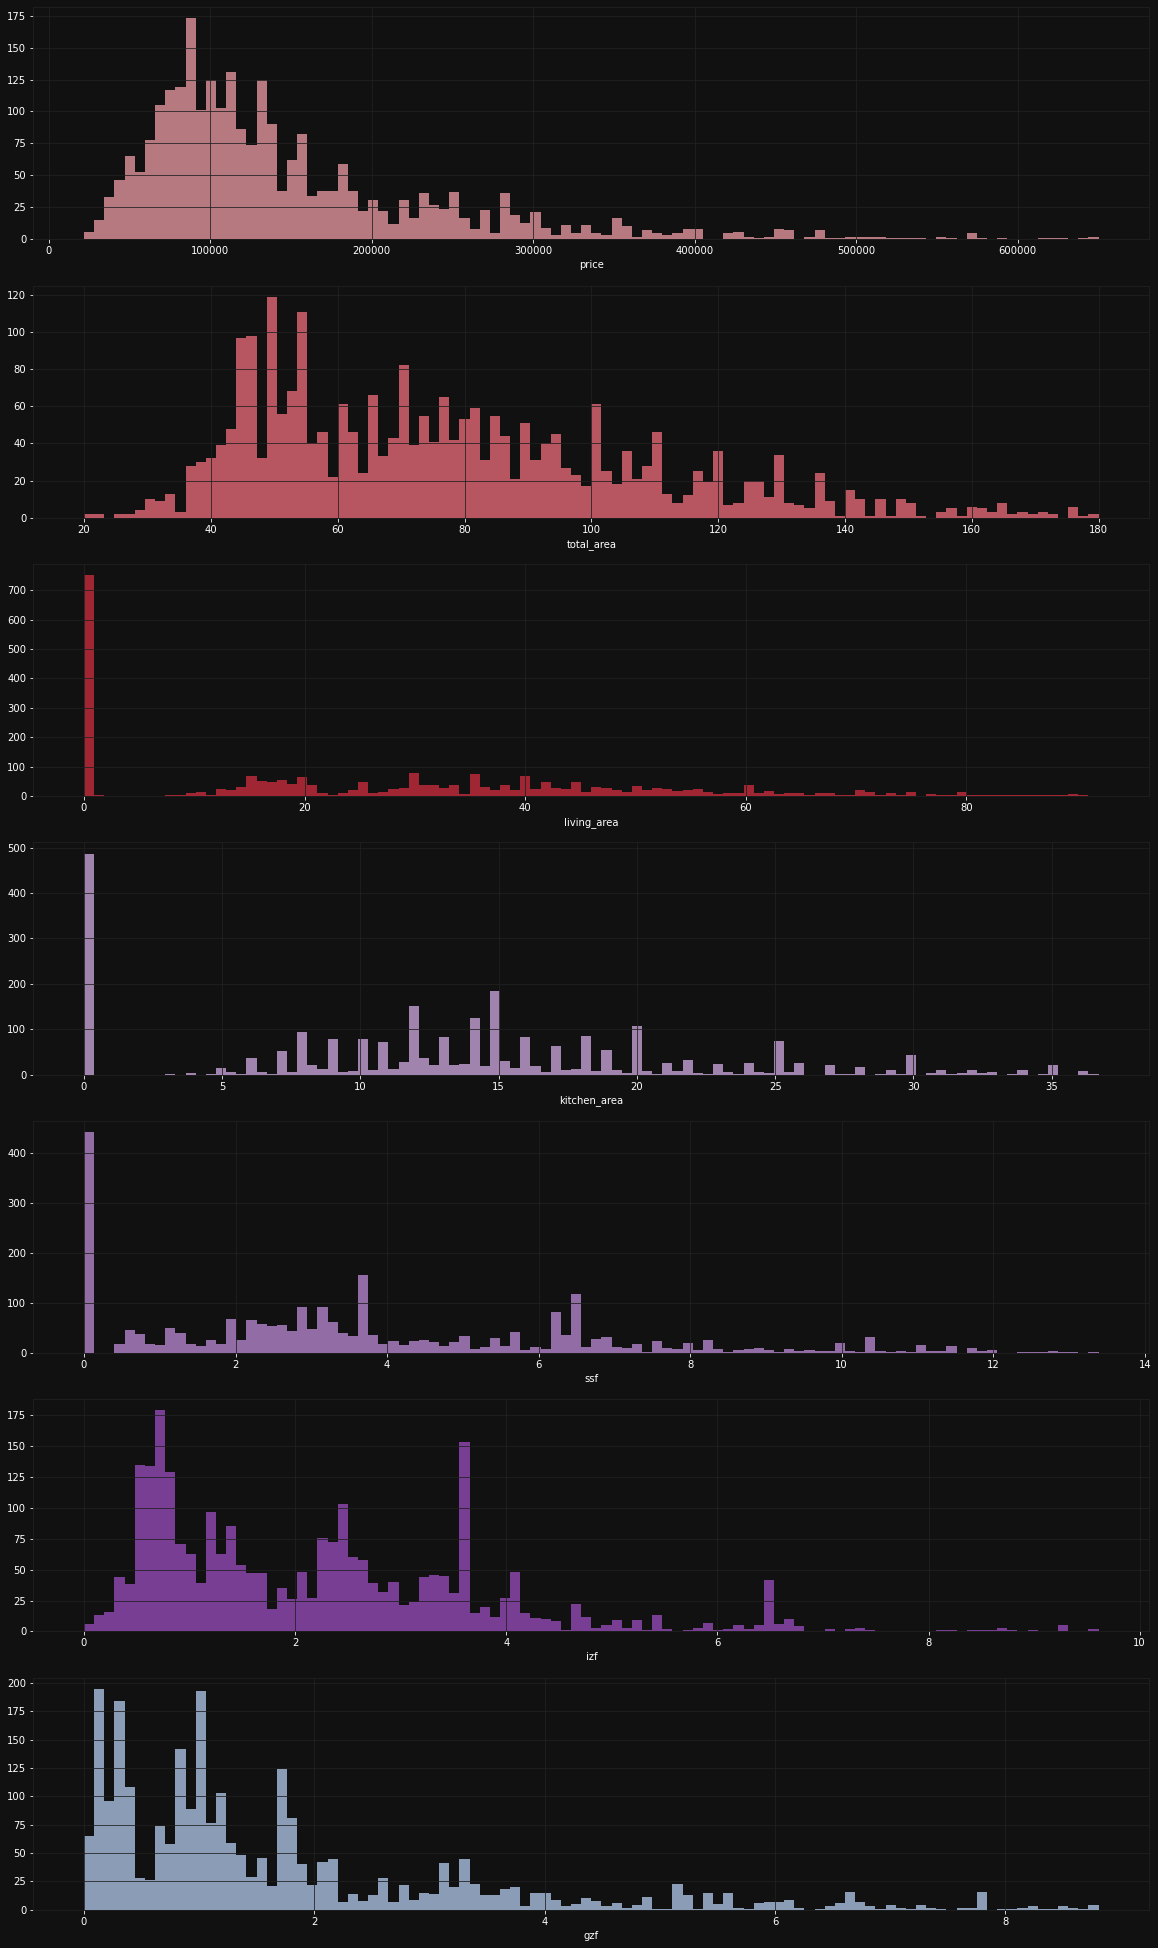

In [43]:
floats = flats.select_dtypes(include='float64')
floats = floats[(abs(zscore(floats)) < 2).all(1)]
axes = subplots(len(floats.columns), figsize=(20, 5 * len(floats.columns)))[1]
for i, column in enumerate(floats.columns):
    distplot(floats[column], ax=axes[i], color=colors[i], bins=100, kde=False, hist_kws={'alpha': 0.7})

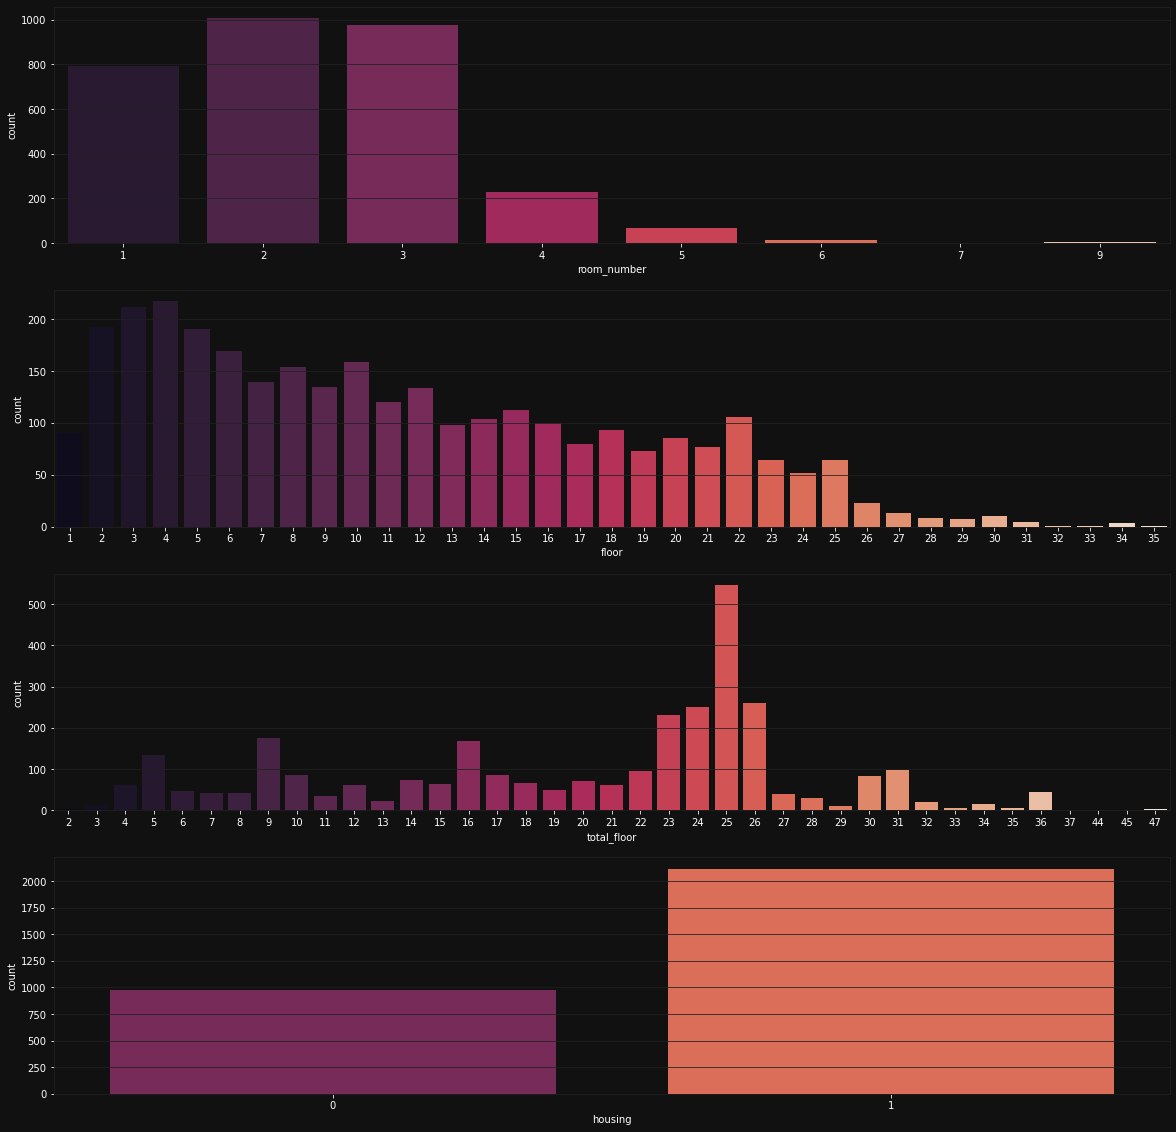

In [44]:
ints = flats.select_dtypes(include='int64')
axes = subplots(len(ints.columns), figsize=(20, 5 * len(ints.columns)))[1]
for i, column in enumerate(ints.columns):
    countplot(flats[column], palette='rocket', ax=axes[i])

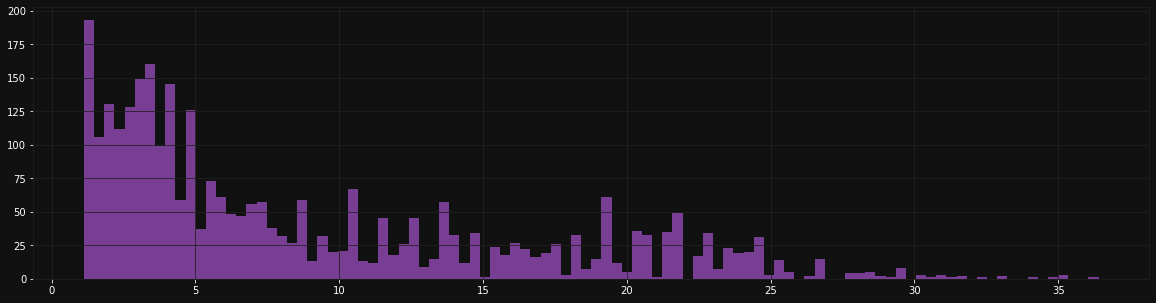

In [48]:
distplot(
    flats['total_floor'] / (1 + exp(0.2 * flats['total_floor'] - 0.3 * flats['floor'])) + 1, 
    ax=subplots(figsize=(20, 5))[1], 
    color=colors[5],
    kde=False,
    bins=100,
    hist_kws={'alpha': 0.7}
)
pass

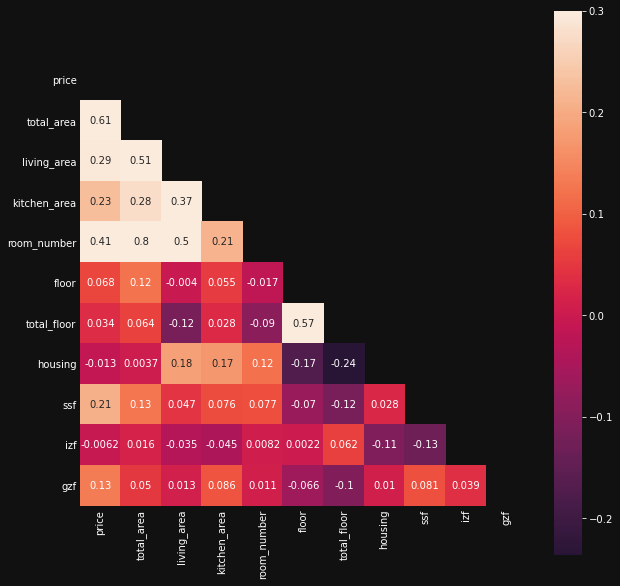

In [55]:
correlation = flats.corr()
axes = subplots(figsize=(10, 10))[1]
axes.tick_params(axis='both', which='both', length=0)
heatmap(
    correlation,
    mask=triu(ones_like(correlation, dtype=bool)),
    ax=axes,
    vmax=0.3,
    center=0,
    annot=True,
    square=True,
    cmap='rocket'
)
pass